# Personal Finance Assistant - Project

**Instructions:** Run each cell in order from top to bottom.

## Install Dependencies

This cell installs all the required Python packages for the backend server, database, OCR, and data visualization. It also installs the Tesseract OCR engine, which is required by the `pytesseract` library.

In [1]:
!pip install -q Flask Flask-SQLAlchemy Flask-JWT-Extended Werkzeug pytesseract Pillow pdf2image tabula-py pandas matplotlib pyngrok fpdf
!sudo apt-get -qq update
!sudo apt-get -qq install -y tesseract-ocr poppler-utils

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## Step 2: Create Project Files

This cell uses 'magic commands' (`%%writefile`) to create the entire directory structure and all the source code for the project. After running this cell, you will see the folders (`backend`, `templates`, etc.) appear in the file explorer on the left.

In [2]:
!mkdir -p backend templates static test_data

### Creating Backend Python Files

In [3]:
%%writefile backend/database.py
from flask_sqlalchemy import SQLAlchemy
db = SQLAlchemy()

Overwriting backend/database.py


In [4]:
%%writefile backend/models.py
from .database import db
from datetime import datetime
from werkzeug.security import generate_password_hash, check_password_hash

class User(db.Model):
    id = db.Column(db.Integer, primary_key=True)
    username = db.Column(db.String(80), unique=True, nullable=False)
    password_hash = db.Column(db.String(256))
    transactions = db.relationship('Transaction', backref='owner', lazy=True)

    def set_password(self, password):
        self.password_hash = generate_password_hash(password)

    def check_password(self, password):
        return check_password_hash(self.password_hash, password)

class Transaction(db.Model):
    id = db.Column(db.Integer, primary_key=True)
    description = db.Column(db.String(200), nullable=False)
    amount = db.Column(db.Float, nullable=False)
    type = db.Column(db.String(10), nullable=False)  # 'income' or 'expense'
    category = db.Column(db.String(50), nullable=False, default='Uncategorized')
    date = db.Column(db.DateTime, nullable=False, default=datetime.utcnow)
    user_id = db.Column(db.Integer, db.ForeignKey('user.id'), nullable=False)

    def to_dict(self):
        return {
            'id': self.id,
            'description': self.description,
            'amount': self.amount,
            'type': self.type,
            'category': self.category,
            'date': self.date.isoformat(),
            'user_id': self.user_id
        }

Overwriting backend/models.py


In [5]:
%%writefile backend/ocr.py
import pytesseract
from PIL import Image
import tabula
import re
from pdf2image import convert_from_path

def extract_text_from_file(filepath):
    try:
        if filepath.lower().endswith('.pdf'):
            images = convert_from_path(filepath)
            text = "\n".join([pytesseract.image_to_string(img) for img in images])
        else:
            image = Image.open(filepath)
            text = pytesseract.image_to_string(image)
        return text
    except Exception as e:
        print(f"Error during text extraction: {e}")
        return ""

def parse_receipt(text):
    data = {'items': [], 'total': None}
    lines = text.split('\n')
    total_found = False
    amount_regex = re.compile(r'([\$€£]?\s*\d+\.\d{2})')

    for line in reversed(lines):
        line_lower = line.strip().lower()
        if ('total' in line_lower or 'amount due' in line_lower) and not total_found:
            match = amount_regex.search(line)
            if match:
                try:
                    data['total'] = float(re.sub(r'[^\d.]', '', match.group(1)))
                    total_found = True
                except ValueError:
                    continue
    return data

def extract_tables_from_pdf(pdf_path):
    try:
        dfs = tabula.read_pdf(pdf_path, pages='all', multiple_tables=True)
        if not dfs:
            return []
        return [df.to_dict(orient='records') for df in dfs]
    except Exception as e:
        return {"error": str(e)}

Overwriting backend/ocr.py


In [6]:
%%writefile backend/app.py
import os
from flask import Flask, request, jsonify, render_template
from datetime import datetime
from werkzeug.utils import secure_filename
from .database import db
from .models import User, Transaction
from .ocr import extract_text_from_file, parse_receipt, extract_tables_from_pdf
from flask_jwt_extended import create_access_token, jwt_required, get_jwt_identity, JWTManager

app = Flask(__name__, template_folder='../templates', static_folder='../static')

# --- Configuration ---
db_path = os.path.join(os.path.abspath(os.path.dirname(__file__)), '../finance.db')
app.config['SQLALCHEMY_DATABASE_URI'] = f'sqlite:///{db_path}'
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
app.config['JWT_SECRET_KEY'] = 'your-super-secret-key-change-it'
app.config['UPLOAD_FOLDER'] = 'uploads'
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

# --- Extensions ---
db.init_app(app)
jwt = JWTManager(app)

with app.app_context():
    db.create_all()

@app.route('/')
def index():
    return render_template('index.html')

# === User Authentication ===
@app.route('/register', methods=['POST'])
def register():
    data = request.get_json()
    if not data or not data.get('username') or not data.get('password'):
        return jsonify({"msg": "Missing username or password"}), 400
    if User.query.filter_by(username=data['username']).first():
        return jsonify({"msg": "User already exists"}), 400

    user = User(username=data['username'])
    user.set_password(data['password'])
    db.session.add(user)
    db.session.commit()
    return jsonify({"msg": "User created successfully"}), 201

@app.route('/login', methods=['POST'])
def login():
    data = request.get_json()
    user = User.query.filter_by(username=data.get('username')).first()
    if user and user.check_password(data.get('password')):
        access_token = create_access_token(identity=str(user.id))
        return jsonify(access_token=access_token)
    return jsonify({"msg": "Bad username or password"}), 401

# === Transactions ===
@app.route('/transactions', methods=['POST'])
@jwt_required()
def add_transaction():
    current_user_id = get_jwt_identity()
    data = request.get_json()
    required = ['description', 'amount', 'type', 'category']
    if not all(k in data for k in required):
        return jsonify({"msg": "Missing fields"}), 400

    try:
        new_transaction = Transaction(
            description=data['description'], amount=float(data['amount']),
            type=data['type'], category=data['category'],
            date=datetime.fromisoformat(data['date']) if 'date' in data else datetime.utcnow(),
            user_id=current_user_id
        )
        db.session.add(new_transaction)
        db.session.commit()
        return jsonify(new_transaction.to_dict()), 201
    except Exception as e:
        db.session.rollback()
        return jsonify({"msg": "Error adding transaction", "error": str(e)}), 500

@app.route('/transactions', methods=['GET'])
@jwt_required()
def get_transactions():
    current_user_id = get_jwt_identity()
    page = request.args.get('page', 1, type=int)
    per_page = request.args.get('per_page', 10, type=int)
    query = Transaction.query.filter_by(user_id=current_user_id)

    if request.args.get('start_date'):
        query = query.filter(Transaction.date >= datetime.fromisoformat(request.args.get('start_date')))
    if request.args.get('end_date'):
        query = query.filter(Transaction.date <= datetime.fromisoformat(request.args.get('end_date')))

    paginated = query.order_by(Transaction.date.desc()).paginate(page=page, per_page=per_page, error_out=False)
    return jsonify({
        "transactions": [t.to_dict() for t in paginated.items],
        "total": paginated.total, "page": paginated.page, "pages": paginated.pages
    })

# === File Processing ===
@app.route('/extract-receipt', methods=['POST'])
@jwt_required()
def upload_receipt():
    if 'file' not in request.files: return jsonify({"msg": "No file part"}), 400
    file = request.files['file']
    if file.filename == '': return jsonify({"msg": "No selected file"}), 400

    filename = secure_filename(file.filename)
    filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
    file.save(filepath)

    try:
        text = extract_text_from_file(filepath)
        parsed_data = parse_receipt(text)
        return jsonify({"raw_text": text, "parsed_data": parsed_data}), 200
    except Exception as e:
        return jsonify({"msg": "Error processing file", "error": str(e)}), 500
    finally:
        if os.path.exists(filepath): os.remove(filepath)

@app.route('/extract-statement', methods=['POST'])
@jwt_required()
def upload_statement():
    if 'file' not in request.files: return jsonify({"msg": "No file part"}), 400
    file = request.files['file']
    if not file.filename.lower().endswith('.pdf'): return jsonify({"msg": "Please upload a PDF"}), 400

    filename = secure_filename(file.filename)
    filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
    file.save(filepath)

    try:
        tables = extract_tables_from_pdf(filepath)
        if "error" in tables: return jsonify(tables), 500
        return jsonify({"extracted_tables": tables}), 200
    except Exception as e:
        return jsonify({"msg": "Error processing PDF", "error": str(e)}), 500
    finally:
        if os.path.exists(filepath): os.remove(filepath)

Overwriting backend/app.py


### Creating HTML and Static Files

In [7]:
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Personal Finance API</title>
    <link rel="stylesheet" href="{{ url_for('static', filename='styles.css') }}">
</head>
<body>
    <h1>Personal Finance Assistant API</h1>
    <p>The API server is running successfully. Use the cells in the Colab notebook to interact with the API endpoints.</p>
</body>
</html>

Overwriting templates/index.html


In [8]:
%%writefile static/styles.css
body { font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif; background-color: #f8f9fa; color: #212529; line-height: 1.6; padding: 20px; }
h1 { color: #007bff; }

Overwriting static/styles.css


### Creating Documentation File

In [9]:
%%writefile README.md
# Personal Finance Assistant

This is a full-stack application designed to help users track, manage, and understand their financial activities, built to run in a Google Colab environment.

## How to Run

Open the `personal_finance_assistant.ipynb` notebook in Google Colab and run all the cells sequentially.

## Implemented Features

### Core Requirements
- **Create Income/Expense Entries**: `POST /transactions`
- **List Entries in Time Range**: `GET /transactions`
- **Show Graphs**: A dedicated cell in the notebook generates a pie chart for expenses.
- **Extract from Receipt**: `POST /extract-receipt` for images and PDFs.

### Bonus Features
- **Support Tabular PDF Upload**: `POST /extract-statement`
- **API Pagination**: Implemented on the `GET /transactions` endpoint.
- **Multi-user Support**: Full user registration, login, and JWT-based authentication.

Overwriting README.md


## Step 3: Create Sample Data for Testing

To make testing the file upload features easy, this cell programmatically creates a sample receipt image and a sample statement PDF.

In [10]:
from PIL import Image, ImageDraw, ImageFont
from fpdf import FPDF

# Create a sample receipt image
try:
    img = Image.new('RGB', (300, 200), color = (255, 255, 255))
    d = ImageDraw.Draw(img)
    # In Colab, a default font path is needed if a specific .ttf is not uploaded
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    d.text((10,10), "CAFE-BOT", fill=(0,0,0), font=font)
    d.text((10,40), "Coffee......₹4.50", fill=(0,0,0), font=font)
    d.text((10,60), "Muffin......₹3.50", fill=(0,0,0), font=font)
    d.text((10,90), "TOTAL.......₹8.00", fill=(0,0,0), font=font)
    img.save('test_data/sample_receipt.png')
    print("Created test_data/sample_receipt.png")
except Exception as e:
    print(f"Error creating sample image: {e}")
    print("Continuing without sample image.")

# Create a sample statement PDF with a table
pdf = FPDF()
pdf.add_page()
pdf.set_font("Helvetica", size=12)
pdf.cell(200, 10, txt="Bank Statement", ln=True, align='C')
pdf.ln(10)

header = ['Date', 'Description', 'Amount']
data = [
    ['2025-09-01', 'Salary', '3000.00'],
    ['2025-09-02', 'Groceries', '-75.50'],
    ['2025-09-03', 'Gas Station', '-45.20'],
]

col_width = pdf.w / 3.5
row_height = pdf.font_size * 1.5

for h in header:
    pdf.cell(col_width, row_height, h, border=1)
pdf.ln(row_height)

for row in data:
    for item in row:
        pdf.cell(col_width, row_height, item, border=1)
    pdf.ln(row_height)

pdf.output('test_data/sample_statement.pdf')
print("Created test_data/sample_statement.pdf")

Created test_data/sample_receipt.png
Created test_data/sample_statement.pdf


## Step 4: Run the Backend Server

This cell will start the Flask web server as a background process. We then use `pyngrok` to create a secure public URL to our local server. This allows us to send API requests to it from within this notebook.

**Please wait for this cell to output a public URL (e.g., `https://*.ngrok.io`) before proceeding.**

In [11]:
import subprocess
import time
from pyngrok import ngrok
import os
import requests
from google.colab import userdata

# --- Install Gunicorn and Start the Server ---
print("Installing Gunicorn...")
!pip install -q gunicorn

print("Starting Flask server in the background...")
proc = subprocess.Popen(["gunicorn", "-w", "1", "-b", "0.0.0.0:5000", "backend.app:app"])


# --- Wait for the Server to be Ready ---
print("Waiting for the server to become available...")
server_ready = False
for _ in range(10):  # Try for up to 20 seconds
    try:
        # Attempt to connect to the local server port
        requests.get("http://localhost:5000", timeout=1)
        print("✅ Server is up and running!")
        server_ready = True
        break
    except requests.exceptions.ConnectionError:
        time.sleep(2) # Wait 2 seconds before retrying

if not server_ready:
    raise RuntimeError("Server did not become available. Killing process.")


# --- Set up ngrok ---
print("Starting ngrok tunnel...")
try:
    # Securely get the authtoken from Colab's Secret Manager
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    if NGROK_AUTH_TOKEN is None:
        raise ValueError("Ngrok authtoken not found in Colab secrets.")

    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

    public_url = ngrok.connect(5000)
    BASE_URL = public_url.public_url
    print(f"🔗 Public URL: {BASE_URL}")

except Exception as e:
    print(f"❌ Ngrok error: {e}")
    print("Killing background server due to ngrok failure.")
    proc.kill()
    BASE_URL = None

Installing Gunicorn...
Starting Flask server in the background...
Waiting for the server to become available...
✅ Server is up and running!
Starting ngrok tunnel...
🔗 Public URL: https://extemporally-burry-sabina.ngrok-free.dev


## Step 5: API Client and Testing

Now that the server is running, we can use the `requests` library to interact with our API endpoints.

In [12]:
import requests
import json

# Helper function to print JSON nicely
def print_json(data):
    print(json.dumps(data, indent=2))

headers = {'Content-Type': 'application/json'}
auth_token = None

# Check if the server is running
if BASE_URL:
    try:
        response = requests.get(BASE_URL)
        print(f"Server status: {response.status_code}")
        if response.status_code != 200:
             print("Server might not be ready. Please check the output of the previous cell.")
    except requests.exceptions.RequestException as e:
        print(f"Could not connect to server: {e}")
else:
    print("Server URL not available. Please re-run the previous cell.")

Server status: 200


### 5.1 - User Registration and Login



In [13]:
user_credentials = {
    "username": "testuser",
    "password": "password123"
}

# Register
print("--- Registering User ---")
register_url = f"{BASE_URL}/register"
response = requests.post(register_url, json=user_credentials, headers=headers)
print(f"Status: {response.status_code}")
print_json(response.json())

# Login
print("\n--- Logging In ---")
login_url = f"{BASE_URL}/login"
response = requests.post(login_url, json=user_credentials, headers=headers)
print(f"Status: {response.status_code}")
if response.status_code == 200:
    auth_token = response.json().get('access_token')
    print("Login successful. Auth token stored.")
else:
    print_json(response.json())

--- Registering User ---
Status: 400
{
  "msg": "User already exists"
}

--- Logging In ---
Status: 200
Login successful. Auth token stored.


### 5.2 - Add Income/Expense Entries

In [14]:
if auth_token:
    auth_headers = headers.copy()
    auth_headers['Authorization'] = f'Bearer {auth_token}'

    transactions_url = f"{BASE_URL}/transactions"

    # Add Income
    income = {
        "description": "Monthly Salary", "amount": 45000, "type": "income", "category": "Salary", "date": "2025-09-01T10:00:00"
    }

    print("--- Adding Income ---")
    response = requests.post(transactions_url, json=income, headers=auth_headers)
    print_json(response.json())

    # Add Expenses
    expenses = [
        {"description": "PG/Apartment", "amount": 14000, "type": "expense", "category": "Rent", "date": "2025-09-02T11:00:00"},
        {"description": "SIP 1", "amount": 5000, "type": "expense", "category": "Mutual Fund", "date": "2025-09-04T11:00:00"},
        {"description": "Groceries", "amount": 650.75, "type": "expense", "category": "Food", "date": "2025-09-05T18:30:00"},
        {"description": "Restaurant", "amount": 580.45, "type": "expense", "category": "Food", "date": "2025-09-12T18:30:00"},
        {"description": "Movie Tickets", "amount": 175.00, "type": "expense", "category": "Entertainment", "date": "2025-09-12T20:00:00"},
        {"description": "Notebooks", "amount": 450.50, "type": "expense", "category": "Education", "date": "2025-09-14T15:00:00"},
        {"description": "SIP 2", "amount": 3000, "type": "expense", "category": "Mutual Fund", "date": "2025-09-18T11:00:00"},
        {"description": "Music Streaming Subscription", "amount": 150.00, "type": "expense", "category": "Entertainment", "date": "2025-09-18T08:00:00"}
    ]
    print("\n--- Adding Expenses ---")
    for expense_data in expenses:
        response = requests.post(transactions_url, json=expense_data, headers=auth_headers)
        print_json(response.json())
else:
    print("Cannot proceed: Not authenticated.")

--- Adding Income ---
{
  "amount": 45000.0,
  "category": "Salary",
  "date": "2025-09-01T10:00:00",
  "description": "Monthly Salary",
  "id": 28,
  "type": "income",
  "user_id": 1
}

--- Adding Expenses ---
{
  "amount": 14000.0,
  "category": "Rent",
  "date": "2025-09-02T11:00:00",
  "description": "PG/Apartment",
  "id": 29,
  "type": "expense",
  "user_id": 1
}
{
  "amount": 5000.0,
  "category": "Mutual Fund",
  "date": "2025-09-04T11:00:00",
  "description": "SIP 1",
  "id": 30,
  "type": "expense",
  "user_id": 1
}
{
  "amount": 650.75,
  "category": "Food",
  "date": "2025-09-05T18:30:00",
  "description": "Groceries",
  "id": 31,
  "type": "expense",
  "user_id": 1
}
{
  "amount": 580.45,
  "category": "Food",
  "date": "2025-09-12T18:30:00",
  "description": "Restaurant",
  "id": 32,
  "type": "expense",
  "user_id": 1
}
{
  "amount": 175.0,
  "category": "Entertainment",
  "date": "2025-09-12T20:00:00",
  "description": "Movie Tickets",
  "id": 33,
  "type": "expense",
 

### 5.3 - List Transactions with Filtering and Pagination

In [15]:
if auth_token:
    transactions_url = f"{BASE_URL}/transactions"

    # List all transactions (paginated)
    print("--- Listing All Transactions (Page 1, 3 per page) ---")
    params = {'page': 1, 'per_page': 3}
    response = requests.get(transactions_url, headers=auth_headers, params=params)
    print_json(response.json())

    # Filter by date range
    print("\n--- Filtering Transactions from 2025-09-01 to 2025-09-08 ---")
    params = {'start_date': '2025-09-01', 'end_date': '2025-09-24'}
    response = requests.get(transactions_url, headers=auth_headers, params=params)
    print_json(response.json())
else:
    print("Cannot proceed: Not authenticated.")

--- Listing All Transactions (Page 1, 3 per page) ---
{
  "page": 1,
  "pages": 12,
  "total": 36,
  "transactions": [
    {
      "amount": 3000.0,
      "category": "Mutual Fund",
      "date": "2025-09-18T11:00:00",
      "description": "SIP 2",
      "id": 8,
      "type": "expense",
      "user_id": 1
    },
    {
      "amount": 3000.0,
      "category": "Mutual Fund",
      "date": "2025-09-18T11:00:00",
      "description": "SIP 2",
      "id": 17,
      "type": "expense",
      "user_id": 1
    },
    {
      "amount": 3000.0,
      "category": "Mutual Fund",
      "date": "2025-09-18T11:00:00",
      "description": "SIP 2",
      "id": 26,
      "type": "expense",
      "user_id": 1
    }
  ]
}

--- Filtering Transactions from 2025-09-01 to 2025-09-08 ---
{
  "page": 1,
  "pages": 4,
  "total": 36,
  "transactions": [
    {
      "amount": 3000.0,
      "category": "Mutual Fund",
      "date": "2025-09-18T11:00:00",
      "description": "SIP 2",
      "id": 8,
      "type": "

### 5.4 - Extract Expenses from Receipt

In [16]:
if auth_token:
    receipt_url = f"{BASE_URL}/extract-receipt"
    receipt_path = 'test_data/sample_receipt.png'

    print(f"--- Uploading {receipt_path} for OCR ---")
    with open(receipt_path, 'rb') as f:
        files = {'file': (receipt_path, f, 'image/png')}
        # For file uploads, we don't set Content-Type, requests does it.
        upload_headers = {'Authorization': f'Bearer {auth_token}'}
        response = requests.post(receipt_url, files=files, headers=upload_headers)
        print_json(response.json())
else:
    print("Cannot proceed: Not authenticated.")

--- Uploading test_data/sample_receipt.png for OCR ---
{
  "parsed_data": {
    "items": [],
    "total": 8.0
  },
  "raw_text": "CAFE-BOT\n\nCoffee 04.50\nMuffin 03.50\n\nTOTAL 08.00\n\f"
}


### 5.5 - Extract from Tabular PDF

In [17]:
if auth_token:
    statement_url = f"{BASE_URL}/extract-statement"
    statement_path = 'test_data/sample_statement.pdf'

    print(f"--- Uploading {statement_path} for Table Extraction ---")
    with open(statement_path, 'rb') as f:
        files = {'file': (statement_path, f, 'application/pdf')}
        upload_headers = {'Authorization': f'Bearer {auth_token}'}
        response = requests.post(statement_url, files=files, headers=upload_headers)
        print_json(response.json())
else:
    print("Cannot proceed: Not authenticated.")

--- Uploading test_data/sample_statement.pdf for Table Extraction ---
{
  "extracted_tables": [
    [
      {
        "Amount": 3000.0,
        "Date": "2025-09-01",
        "Description": "Salary"
      },
      {
        "Amount": -75.5,
        "Date": "2025-09-02",
        "Description": "Groceries"
      },
      {
        "Amount": -45.2,
        "Date": "2025-09-03",
        "Description": "Gas Station"
      }
    ]
  ]
}


### 5.6 - Show Graphs

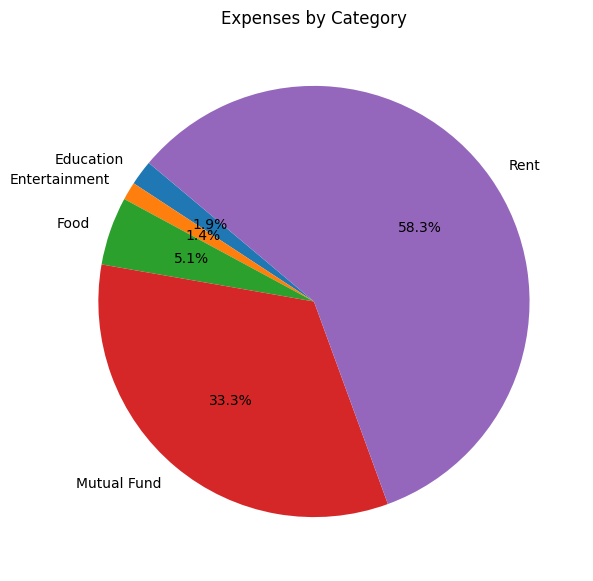

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

if auth_token:
    # Fetch all transactions (by setting a high per_page value)
    response = requests.get(f"{BASE_URL}/transactions?per_page=100", headers=auth_headers)
    if response.status_code == 200:
        all_transactions = response.json().get('transactions', [])

        # Filter for expenses and create a DataFrame
        expenses_data = [t for t in all_transactions if t['type'] == 'expense']
        if expenses_data:
            df = pd.DataFrame(expenses_data)

            # Group by category and sum amounts
            expense_by_category = df.groupby('category')['amount'].sum()

            # Plotting
            plt.figure(figsize=(10, 7))
            expense_by_category.plot(kind='pie', autopct='%1.1f%%', startangle=140)
            plt.title('Expenses by Category')
            plt.ylabel('') # Hide the y-label
            plt.show()
        else:
            print("No expense data found to generate a graph.")
    else:
        print("Failed to fetch transactions for graphing.")
else:
    print("Cannot proceed: Not authenticated.")

### 5.7 - Bar Graph of Daily Expenses

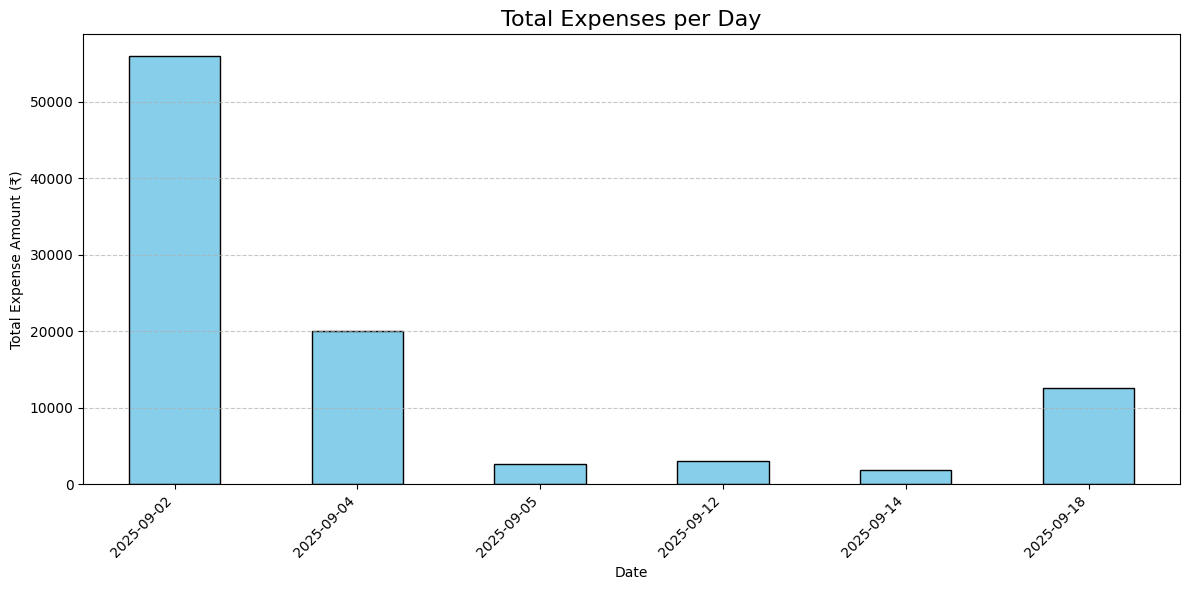

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

if auth_token:
    # Fetch all transactions by setting a high per_page value
    response = requests.get(f"{BASE_URL}/transactions?per_page=1000", headers=auth_headers)
    if response.status_code == 200:
        all_transactions = response.json().get('transactions', [])

        # Filter for expenses and create a DataFrame
        expenses_data = [t for t in all_transactions if t['type'] == 'expense']

        if expenses_data:
            df = pd.DataFrame(expenses_data)

            # Convert date strings to datetime objects
            df['date'] = pd.to_datetime(df['date'])

            # Extract just the date part (ignoring time) for grouping
            df['day'] = df['date'].dt.date

            # Group by day and sum the amounts
            daily_expenses = df.groupby('day')['amount'].sum().sort_index()

            # Plotting the bar graph
            plt.figure(figsize=(12, 6))
            daily_expenses.plot(kind='bar', color='skyblue', edgecolor='black')

            plt.title('Total Expenses per Day', fontsize=16)
            plt.xlabel('Date')
            plt.ylabel('Total Expense Amount (₹)')
            plt.xticks(rotation=45, ha='right') # Rotate date labels for readability
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout() # Adjust layout to prevent labels from being cut off
            plt.show()

        else:
            print("No expense data found to generate a graph.")
    else:
        print(f"Failed to fetch transactions for graphing. Status: {response.status_code}")
else:
    print("Cannot proceed: Not authenticated.")

### 5.8 - Income vs. Expense Comparison

--- Financial Summary ---
Total Income:    ₹180,000.00
Total Expenses: -₹96,026.80
-------------------------
Net Savings:     ₹83,973.20



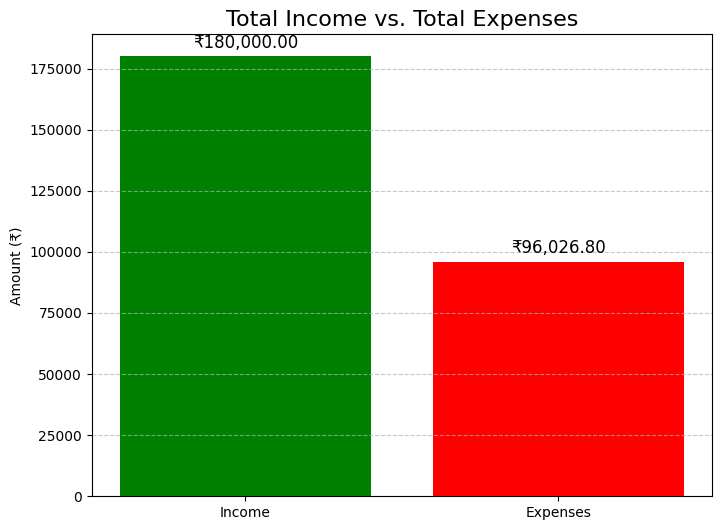

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

if auth_token:
    # Fetch all transactions by setting a high per_page value
    response = requests.get(f"{BASE_URL}/transactions?per_page=1000", headers=auth_headers)

    if response.status_code == 200:
        all_transactions = response.json().get('transactions', [])

        if all_transactions:
            df = pd.DataFrame(all_transactions)

            # Calculate total income
            total_income = df[df['type'] == 'income']['amount'].sum()

            # Calculate total expenses
            total_expenses = df[df['type'] == 'expense']['amount'].sum()

            # Calculate net savings
            net_savings = total_income - total_expenses

            # --- Print a Summary ---
            print("--- Financial Summary ---")
            print(f"Total Income:    ₹{total_income:,.2f}")
            print(f"Total Expenses: -₹{total_expenses:,.2f}")
            print("-------------------------")
            print(f"Net Savings:     ₹{net_savings:,.2f}\n")

            # --- Plotting the Bar Chart ---
            labels = ['Income', 'Expenses']
            totals = [total_income, total_expenses]
            colors = ['green', 'red']

            plt.figure(figsize=(8, 6))
            plt.bar(labels, totals, color=colors)

            plt.title('Total Income vs. Total Expenses', fontsize=16)
            plt.ylabel('Amount (₹)')
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Add the total amount on top of each bar
            for i, total in enumerate(totals):
                plt.text(i, total + (max(totals) * 0.02), f'₹{total:,.2f}', ha='center', fontsize=12)

            plt.show()

        else:
            print("No transaction data found to generate a summary.")
    else:
        print(f"Failed to fetch transactions for summary. Status: {response.status_code}")
else:
    print("Cannot proceed: Not authenticated.")

## Step 6: Clean Up

This final cell will shut down the background server and the ngrok tunnel.

In [21]:
print("Shutting down server and ngrok tunnel...")
proc.kill() # Kill the gunicorn process
ngrok.kill() # Kill the ngrok tunnel
print("Cleanup complete.")

Shutting down server and ngrok tunnel...
Cleanup complete.
